# Simple Semantic Search

In [13]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
import pickle 
import os

In [14]:
# === 1. Load model IndoSBERT dari Denaya ===
model = SentenceTransformer("denaya/indoSBERT-large")

In [15]:
# === 2. Load dataset ===
df = pd.read_csv("../quran_id_full.csv")
texts = df['indoText'].tolist()

In [7]:
# === 3. Cek apakah embedding sudah disimpan ===
embedding_file = "quran_id_full_embedding_indosbert.pkl"
if os.path.exists(embedding_file):
    with open(embedding_file, "rb") as f:
        embeddings = pickle.load(f)
    print("✅ Embedding berhasil dimuat dari file.")
else:
    embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
    with open(embedding_file, "wb") as f:
        pickle.dump(embeddings, f)
    print("✅ Embedding berhasil dihitung dan disimpan.")

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

✅ Embedding berhasil dihitung dan disimpan.


In [13]:
# === 4. Proses IR / Semantic Search ===
def search(query, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]
    results = []
    for hit in hits:
        idx = hit['corpus_id']
        score = hit['score']
        results.append((df.iloc[idx]['suraId'], df.iloc[idx]['verseID'], df.iloc[idx]['indoText'], score))
    return results

In [16]:
# === 5. Contoh Query ===
query = "kasih sayang Tuhan"
hasil = search(query, 20)

In [17]:
# === 6. Cetak hasil pencarian ===
for surah, ayat, text, score in hasil:
    print(f"[{surah}:{ayat}] (score: {score:.4f})\n{text}\n")

[26:217] (score: 0.7148)
Dan bertawakallah kepada (Allah) Yang Mahaperkasa, Maha Penyayang.

[55:1] (score: 0.7148)
(Allah) Yang Maha Pengasih,

[1:3] (score: 0.7097)
Yang Maha Pengasih, Maha Penyayang,

[1:1] (score: 0.7073)
Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.

[26:9] (score: 0.7032)
Dan sungguh, Tuhanmu Dialah Yang Mahaperkasa, Maha Penyayang.

[74:3] (score: 0.6962)
dan agungkanlah Tuhanmu,

[26:68] (score: 0.6944)
Dan sesungguhnya Tuhanmu Dialah Yang Mahaperkasa, Maha Penyayang.

[26:159] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:122] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:191] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah yang Mahaperkasa, Maha Penyayang.

[26:140] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:175] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:104] (score: 0.6940)
Dan sungguh, Tuhanmu be

# Cek Max Seq Len

In [ ]:
tokenizer = model.tokenizer 
max_len = model.max_seq_length 

In [17]:
def count_tokens(text):
    return len(tokenizer.tokenize(text))

In [20]:
jumlah_token_ayats = [count_tokens(text) for text in texts]

Token indices sequence length is longer than the specified maximum sequence length for this model (317 > 256). Running this sequence through the model will result in indexing errors


In [25]:
import numpy as np

token_array = np.array(jumlah_token_ayats)
print("Min   :", np.min(token_array))
print("Max   :", np.max(token_array))
print("Mean  :", np.mean(token_array))
print("Median:", np.median(token_array))
print("Std   :", np.std(token_array))

Min   : 2
Max   : 317
Mean  : 34.24326491340603
Median: 28.0
Std   : 24.38255472348762


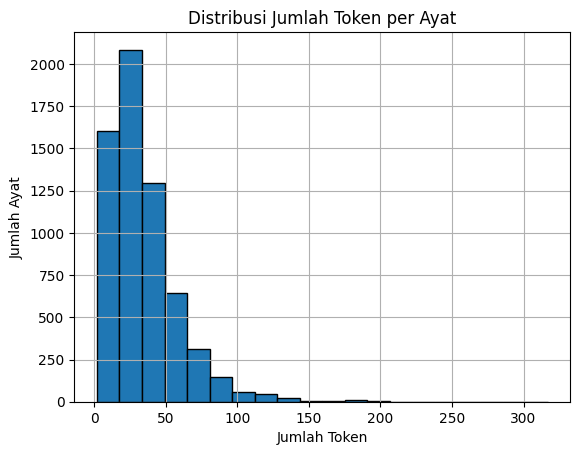

In [21]:
import matplotlib.pyplot as plt

plt.hist(jumlah_token_ayats, bins=20, edgecolor='black')
plt.title("Distribusi Jumlah Token per Ayat")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Ayat")
plt.grid(True)
plt.show()

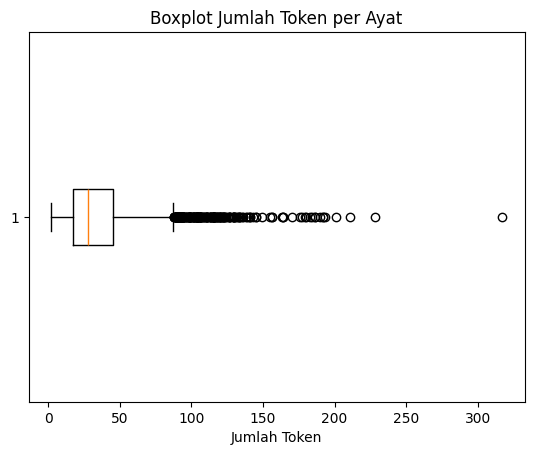

In [22]:
plt.boxplot(jumlah_token_ayats, vert=False)
plt.title("Boxplot Jumlah Token per Ayat")
plt.xlabel("Jumlah Token")
plt.show()

# Manualisasi

In [2]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
import torch.nn.functional as F


In [3]:
# Load dataset
df = pd.read_csv("../quran_100_ayat.csv")

# Ambil teks ayat saja
corpus = df['indoText'].tolist()

In [4]:
query = "kasih sayang Tuhan"

In [ ]:
MODEL_NAME = "denaya/indoSBERT-large"

## encode()

In [12]:
model = SentenceTransformer(MODEL_NAME)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 1024, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [ ]:
df = pd.read_csv("../quran_100_ayat.csv")
texts = df['indoText'].tolist()

In [16]:
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
def search(query, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]
    results = []
    for hit in hits:
        idx = hit['corpus_id']
        score = hit['score']
        results.append((df.iloc[idx]['suraId'], df.iloc[idx]['verseID'], df.iloc[idx]['indoText'], score))
    return results

In [21]:
hasil = search(query)

In [22]:
for surah, ayat, text, score in hasil:
    print(f"[{surah}:{ayat}] (score: {score:.4f})\n{text}\n")

[1:3] (score: 0.7097)
Yang Maha Pengasih, Maha Penyayang,

[1:1] (score: 0.7073)
Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.

[1:5] (score: 0.6671)
Hanya kepada Engkaulah kami menyembah dan hanya kepada Engkaulah kami mohon pertolongan.

[1:2] (score: 0.6662)
Segala puji bagi Allah, Tuhan seluruh alam,

[2:45] (score: 0.5204)
Dan mohonlah pertolongan (kepada Allah) dengan sabar dan salat. Dan (salat) itu sungguh berat, kecuali bagi orang-orang yang khusyuk,



## AutoEncoder

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

In [6]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # [batch_size, seq_len, hidden_size]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask  # [batch_size, hidden_size]

def dense_projection(embeddings):
    dense = torch.nn.Linear(embeddings.shape[1], embeddings.shape[1])
    torch.nn.init.xavier_uniform_(dense.weight)
    torch.nn.init.zeros_(dense.bias)
    projected = torch.tanh(dense(embeddings))
    return projected



In [7]:
# Tokenisasi
encoded_corpus = tokenizer(corpus, padding=True, truncation=True, return_tensors='pt')

# Forward pass
with torch.no_grad():
    model_output = bert_model(**encoded_corpus)

# Mean pooling
corpus_embeddings = mean_pooling(model_output, encoded_corpus['attention_mask'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# corpus_embeddings = dense_projection(corpus_embeddings)

In [8]:
encoded_query = tokenizer(query, return_tensors='pt', truncation=True, padding=True)

with torch.no_grad():
    query_output = bert_model(**encoded_query)

query_embedding = mean_pooling(query_output, encoded_query['attention_mask'])

In [9]:
similarities = cosine_similarity(query_embedding, corpus_embeddings)  # shape: [N]

# Ambil top-5
top_k = torch.topk(similarities, k=5)
indices = top_k.indices
scores = top_k.values

In [10]:
for idx, score in zip(indices, scores):
    row = df.iloc[idx.item()]
    print(f"[{row['suraId']}:{row['verseID']}] (score: {score:.4f})\n{row['indoText']}\n")

[1:3] (score: 0.6833)
Yang Maha Pengasih, Maha Penyayang,

[1:2] (score: 0.6679)
Segala puji bagi Allah, Tuhan seluruh alam,

[1:1] (score: 0.6540)
Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.

[1:5] (score: 0.5999)
Hanya kepada Engkaulah kami menyembah dan hanya kepada Engkaulah kami mohon pertolongan.

[2:40] (score: 0.4742)
Wahai Bani Israil! Ingatlah nikmat-Ku yang telah Aku berikan kepadamu. Dan penuhilah janjimu kepada-Ku, niscaya Aku penuhi janji-Ku kepadamu, dan takutlah kepada-Ku saja.

